In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="httplib2 transport does not support per-request timeout",
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ee, os, math
import geemap

/opt/conda/envs/gee/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
PROJECT = 'eeps-geospatial'
ee.Initialize(project=PROJECT)
print("EE initialized.")

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


EE initialized.


In [3]:
ASSET   = 'projects/eeps-geospatial/assets/alaska_lakes'
BUCKET  = 'wustl-eeps-geospatial'
YEAR    = 2024
LAKE_ID_FIELD = 'id'            # from your properties
EXPORT_PREFIX = f'exports/Alaska_Lakes_IceDates_{YEAR}'

## Part 1: Export buffered lake data

### Recalculate geometry for each area using EPSG:3338 (Alaska equal-area CRS)

In [4]:
# Original lakes FC
lakes = ee.FeatureCollection('projects/eeps-geospatial/assets/alaska_lakes')

# Alaska Albers Equal Area
proj_ak = ee.Projection('EPSG:3338')

def add_geom_props(feat):
    geom = feat.geometry()
    
    # Recompute total-lake metrics in EPSG:3338
    area_total = geom.area(maxError=1, proj=proj_ak)        # m²
    peri_total = geom.perimeter(maxError=1, proj=proj_ak)   # m
    
    # Compactness = 4πA / P², guard against P=0
    compact = ee.Algorithms.If(
        peri_total.gt(0),
        area_total.multiply(4 * math.pi).divide(peri_total.pow(2)),
        None
    )
    
    # Keep everything that was there, add new fields
    return feat.set({
        'area_m2_3338_total': area_total,
        'perim_m_3338_total': peri_total,
        'compact_3338_total': compact
    })

lakes_with_geom = lakes.map(add_geom_props)

### Create the lake edge buffer - keep central 2/3 of each lake area

In [5]:
INNER_FRACTION = 0.67  # keep central ~67% of area

# Alaska Albers projection (EPSG:3338)
proj_ak = ee.Projection('EPSG:3338')

def area_fraction_buffer(feat):
    geom = feat.geometry()
    
    # Area in EPSG:3338 (m²)
    area = geom.area(maxError=1, proj=proj_ak)
    
    # Treat lake as roughly circular: A ≈ π r² → r ≈ sqrt(A/π)
    pi = ee.Number(math.pi)
    radius_equiv = area.divide(pi).sqrt()  # meters
    
    # Shrink radius by sqrt(INNER_FRACTION) so area shrinks by INNER_FRACTION
    inner_fraction_sqrt = ee.Number(INNER_FRACTION).sqrt()
    target_radius = radius_equiv.multiply(inner_fraction_sqrt)
    
    # Inward buffer distance ≈ (r_full - r_target)
    inner_dist = radius_equiv.subtract(target_radius)  # meters
    
    # Negative buffer = shrink geometry
    buffered = geom.buffer(inner_dist.multiply(-1))
    
    # Fallback if the buffer collapses or becomes empty
    buffered_geom = ee.Geometry(buffered)
    buffered_geom = ee.Algorithms.If(
        buffered_geom.area(maxError=1).gt(0),
        buffered_geom,
        geom  # fall back to full lake
    )
    
    return feat.setGeometry(ee.Geometry(buffered_geom))

# Apply to your lake collection
lakes_buf = lakes_with_geom.map(area_fraction_buffer)

### Map

In [6]:
m = geemap.Map(center=[70.5, -149.5], zoom=9, basemap='CartoDB.Positron')
m.addLayer(lakes.style(color='black', width=1, fillColor='00000000'), {}, 'Lakes original')
m.addLayer(lakes_buf.style(color='red', width=1, fillColor='00000000'), {}, 'Lakes buffered adaptive')
m

Map(center=[70.5, -149.5], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

### Define Feature collection

In [7]:
def s1_collection(geom, year):
    start = ee.Date.fromYMD(year, 1, 1)
    end   = start.advance(1, 'year')
    coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(geom)
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode','IW'))
            .filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH'))  # ADD THIS
            .filter(ee.Filter.eq('resolution_meters',10)))
    def prep(img):
        angle = img.select('angle')
        angle_mask = angle.gt(30).And(angle.lt(45))
        
        # Process VV
        vv_lin = ee.Image(10.0).pow(img.select('VV').divide(10.0)).updateMask(angle_mask)
        vv_lin_f = vv_lin.focal_mean(1)
        vv_db = vv_lin_f.log10().multiply(10).rename('VV_db')
        
        # Process VH (ADD THIS BLOCK)
        vh_lin = ee.Image(10.0).pow(img.select('VH').divide(10.0)).updateMask(angle_mask)
        vh_lin_f = vh_lin.focal_mean(1)
        vh_db = vh_lin_f.log10().multiply(10).rename('VH_db')
        
        # Combine both bands
        return vv_db.addBands(vh_db).copyProperties(img, img.propertyNames()).set('system:time_start', img.get('system:time_start'))
    return coll.map(prep)

s1 = s1_collection(lakes.geometry(), YEAR)
print('S1 images:', s1.size().getInfo())

S1 images: 29


### Outer/landscape buffers

In [ ]:
# Create landscape buffer zones (rings around lakes for context)
def create_landscape_buffer(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)  # 100m ring around lake
    ring = outer_buffer.difference(lake_geom)  # Subtract lake itself
    return feat.setGeometry(ring)

landscape_rings = lakes_with_geom.map(create_landscape_buffer)

### Create SAR time series by lake
Build per-lake, per-date VV/VH dB time series via reduceRegions,
preserving all original properties and adding geometry / buffer metrics.
Include a specific output of Roger's RGB channels assigned to VV, VH, VV-VH

In [12]:
# Build per-lake, per-date VV/VH/RGB time series via reduceRegions

SCALE = 10  # Sentinel-1 GRD resolution in meters

def image_to_features(img):
    # Original VV/VH bands
    vv_img = img.select('VV_db')
    vh_img = img.select('VH_db')
    
    # NEW: Create RGB bands for color analysis
    r_band = vv_img.unitScale(-25, 0).multiply(255).byte().rename('R')
    g_band = vh_img.unitScale(-32, -8).multiply(255).byte().rename('G')
    b_band = vv_img.subtract(vh_img).unitScale(0, 15).multiply(255).byte().rename('B')
    
    # Combine all bands
    combined = ee.Image.cat([vv_img, vh_img, r_band, g_band, b_band])
    
    # Date string for this acquisition
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

    # Reducers for VV/VH (keep your existing approach)
    vv_reducer = ee.Reducer.mean().combine(ee.Reducer.count(), sharedInputs=True)
    vh_reducer = ee.Reducer.mean()
    
    # Reducer for RGB
    rgb_reducer = ee.Reducer.mean()

    # Reduce VV over buffered lakes
    vv_stats = vv_img.reduceRegions(
        collection = lakes_buf,
        reducer    = vv_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )
    
    # Reduce VH over buffered lakes
    vh_stats = vh_img.reduceRegions(
        collection = lakes_buf,
        reducer    = vh_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )
    
    # Reduce RGB over buffered lakes
    rgb_img = ee.Image.cat([r_band, g_band, b_band])
    rgb_stats = rgb_img.reduceRegions(
        collection = lakes_buf,
        reducer    = rgb_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )
    
    # Reduce RGB over landscape rings (for context)
    landscape_stats = rgb_img.reduceRegions(
        collection = landscape_rings,  # you'll need to create this - see below
        reducer    = rgb_reducer,
        scale      = SCALE,
        tileScale  = 2,
    )

    # Attach all metadata
    def add_metadata(f):
        lake_id_prop = f.get(LAKE_ID_FIELD)

        # Get VH stats for this lake
        vh_feature = vh_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        vh_mean_db = ee.Number(vh_feature.get('mean'))
        
        # NEW: Get RGB stats for this lake
        rgb_feature = rgb_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        lake_r = ee.Number(rgb_feature.get('R'))
        lake_g = ee.Number(rgb_feature.get('G'))
        lake_b = ee.Number(rgb_feature.get('B'))
        
        # NEW: Get landscape RGB stats
        land_feature = landscape_stats.filter(ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)).first()
        land_r = ee.Number(land_feature.get('R'))
        land_g = ee.Number(land_feature.get('G'))
        land_b = ee.Number(land_feature.get('B'))

        # Look up original feature for full-lake metrics
        orig = lakes_with_geom.filter(
            ee.Filter.eq(LAKE_ID_FIELD, lake_id_prop)
        ).first()

        geom_full = ee.Algorithms.If(
            orig,
            ee.Feature(orig).geometry(),
            f.geometry()
        )
        geom_full = ee.Geometry(geom_full).transform(proj_ak, 1)
        area_full  = geom_full.area(1)
        perim_full = geom_full.perimeter(1)

        buf_geom  = f.geometry().transform(proj_ak, 1)
        buf_area  = buf_geom.area(1)
        buf_perim = buf_geom.perimeter(1)

        compact_full = (
            ee.Number(area_full)
            .multiply(4.0 * math.pi)
            .divide(ee.Number(perim_full).pow(2))
        )

        pix_count = f.get('count')
        vv_mean_db = ee.Number(f.get('mean'))

        return (f
            # time / backscatter
            .set('date', date_str)
            .set('Year', YEAR)
            .set('vv_db', vv_mean_db)
            .set('vh_db', vh_mean_db)
            
            # NEW: RGB color features
            .set('lake_R', lake_r)
            .set('lake_G', lake_g)
            .set('lake_B', lake_b)
            .set('land_R', land_r)
            .set('land_G', land_g)
            .set('land_B', land_b)

            # full-lake metrics
            .set('lake_area_m2_3338',  area_full)
            .set('lake_perim_m_3338',  perim_full)
            .set('compact_3338_total', compact_full)

            # buffer metrics
            .set('buf_area_m2_3338',   buf_area)
            .set('buf_perim_m_3338',   buf_perim)
            .set('pix_count_buf',      pix_count)

            .set('lake_id', ee.Number(lake_id_prop).toInt())
        )

    return vv_stats.map(add_metadata)

# Map over all S1 images
nested  = s1.map(image_to_features)
lake_ts = ee.FeatureCollection(nested).flatten()

### Export to CSV
Exports all the data to a CSV file stored in a GCS bucket. This takes a while to run: 1-2 hours. Check status in Terminal with  
`
earthengine task info [task.id]
`  
The task.id number is at the bottom of the cell

In [13]:
EXPORT_PREFIX = f'exports/Alaska_Lakes_S1timeseries_{YEAR}'

cols = [
    'lake_id',          
    'Year',
    'date',
    'vv_db',
    'vh_db',
    # RGB color features
    'lake_R',
    'lake_G', 
    'lake_B',
    'land_R',
    'land_G',
    'land_B',
    # Original shapefile attributes
    'Shape_Area',
    'Shape_Leng',
    'area',
    'circularit',
    'lat',
    'lon',
    'perimeter',
    # Geometry metrics
    'lake_area_m2_3338',
    'lake_perim_m_3338',
    'compact_3338_total',
    'buf_area_m2_3338',
    'buf_perim_m_3338',
    'pix_count_buf',
]

# Rest of export cell stays the same

task = ee.batch.Export.table.toCloudStorage(
    collection     = lake_ts.select(cols),
    description    = f'Alaska_Lakes_S1timeseries_{YEAR}',
    bucket         = BUCKET,
    fileNamePrefix = EXPORT_PREFIX,
    fileFormat     = 'CSV',
    selectors      = cols,
)
task.start()
print('Started export task:', task.id)

Started export task: AASX4FBPBVR3VW5NLRBBMD5Z


## Part 2: Process exported csv

In [15]:
!gsutil cp gs://wustl-eeps-geospatial/exports/Alaska_Lakes_S1timeseries_2024.csv .

Copying gs://wustl-eeps-geospatial/exports/Alaska_Lakes_S1timeseries_2024.csv...
/ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      


In [16]:
csv_path = "Alaska_Lakes_S1timeseries_2024.csv"
df = pd.read_csv(csv_path)

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# If lake_id is missing for any reason, rebuild it from id
if 'lake_id' not in df.columns:
    df['lake_id'] = df['id'].round().astype('Int64')

# Dual-pol features
df['vv_lin'] = 10.0 ** (df['vv_db'] / 10.0)
df['vh_lin'] = 10.0 ** (df['vh_db'] / 10.0)

df['vv_minus_vh_db'] = df['vv_db'] - df['vh_db']
df['vv_vh_ratio_lin'] = df['vv_lin'] / df['vh_lin'].replace(0, np.nan)

In [17]:
def process_lake(g, run_len=2,
                 spring_months=(3, 7),
                 fall_months=(8, 12)):
    """
    g: DataFrame for a single lake (one 'id')
    run_len: how many consecutive images to require for a valid state
    spring_months: (start, end) for break-up search
    fall_months: (start, end) for freeze-up search
    """
    g = g.sort_values('date').reset_index(drop=True)

    # Skip lakes with no valid VV
    if g['vv_db'].isna().all():
        return pd.Series({
            'Year': g['Year'].iloc[0] if 'Year' in g else np.nan,
            'threshold_vv_db': np.nan,
            'Last_Full_Ice_Day': pd.NaT,
            'First_No_Ice_Day': pd.NaT,
            'Last_No_Ice_Day': pd.NaT,
            'First_Full_Ice_Day': pd.NaT,
        })

    # Lake-specific threshold
    q20, q80 = g['vv_db'].quantile([0.2, 0.8])
    thr = 0.5 * (q20 + q80)

    # 1 = ice, 0 = open water
    g['state_raw'] = (g['vv_db'] >= thr).astype(int)

    # Rolling median over 3 images to smooth noise
    g['state'] = (
        g['state_raw']
        .rolling(window=3, center=True, min_periods=1)
        .median()
        .round()
        .astype(int)
    )

    g['month'] = g['date'].dt.month

    def first_run(month_min, month_max, target_state, run_len):
        """First date with >= run_len consecutive target_state in the given month window."""
        sub = g[(g['month'] >= month_min) & (g['month'] <= month_max)].copy()
        if sub.empty:
            return pd.NaT

        mask = (sub['state'] == target_state)
        arr = mask.to_numpy().astype(int)
        if arr.size < run_len:
            return pd.NaT

        conv = np.convolve(arr, np.ones(run_len, dtype=int), mode='valid')
        hits = np.where(conv == run_len)[0]
        if hits.size == 0:
            return pd.NaT

        # index of the first image in the first valid run
        first_idx = sub.index[hits[0]]
        return g.loc[first_idx, 'date']

    # Parameters
    spring_start, spring_end = spring_months
    fall_start, fall_end = fall_months

    # Break-up: open water (state=0) run in spring
    first_no_ice = first_run(spring_start, spring_end, target_state=0, run_len=run_len)

    # Freeze-up: ice (state=1) run in fall
    first_full_ice = first_run(fall_start, fall_end, target_state=1, run_len=run_len)

    # Last full ice day: last ice date before the break-up date
    if pd.isna(first_no_ice):
        last_full_ice = pd.NaT
    else:
        mask = (g['date'] < first_no_ice) & (g['state'] == 1)
        last_full_ice = g.loc[mask, 'date'].max() if mask.any() else pd.NaT

    # Last no-ice day: last water date in fall before freeze-up
    if pd.isna(first_full_ice):
        last_no_ice = pd.NaT
    else:
        mask = (
            (g['date'] < first_full_ice) &
            (g['state'] == 0) &
            (g['month'] >= fall_start)
        )
        last_no_ice = g.loc[mask, 'date'].max() if mask.any() else pd.NaT

    return pd.Series({
        'Year': g['Year'].iloc[0] if 'Year' in g else 2024,
        'threshold_vv_db': thr,
        'Last_Full_Ice_Day': last_full_ice,
        'First_No_Ice_Day': first_no_ice,
        'Last_No_Ice_Day': last_no_ice,
        'First_Full_Ice_Day': first_full_ice,
    })

In [18]:
summary = (
    df
    .groupby('lake_id', group_keys=False)
    .apply(process_lake, run_len=2)  # or 3 if you want stricter runs
    .reset_index()
)

summary.head()
df_events = summary

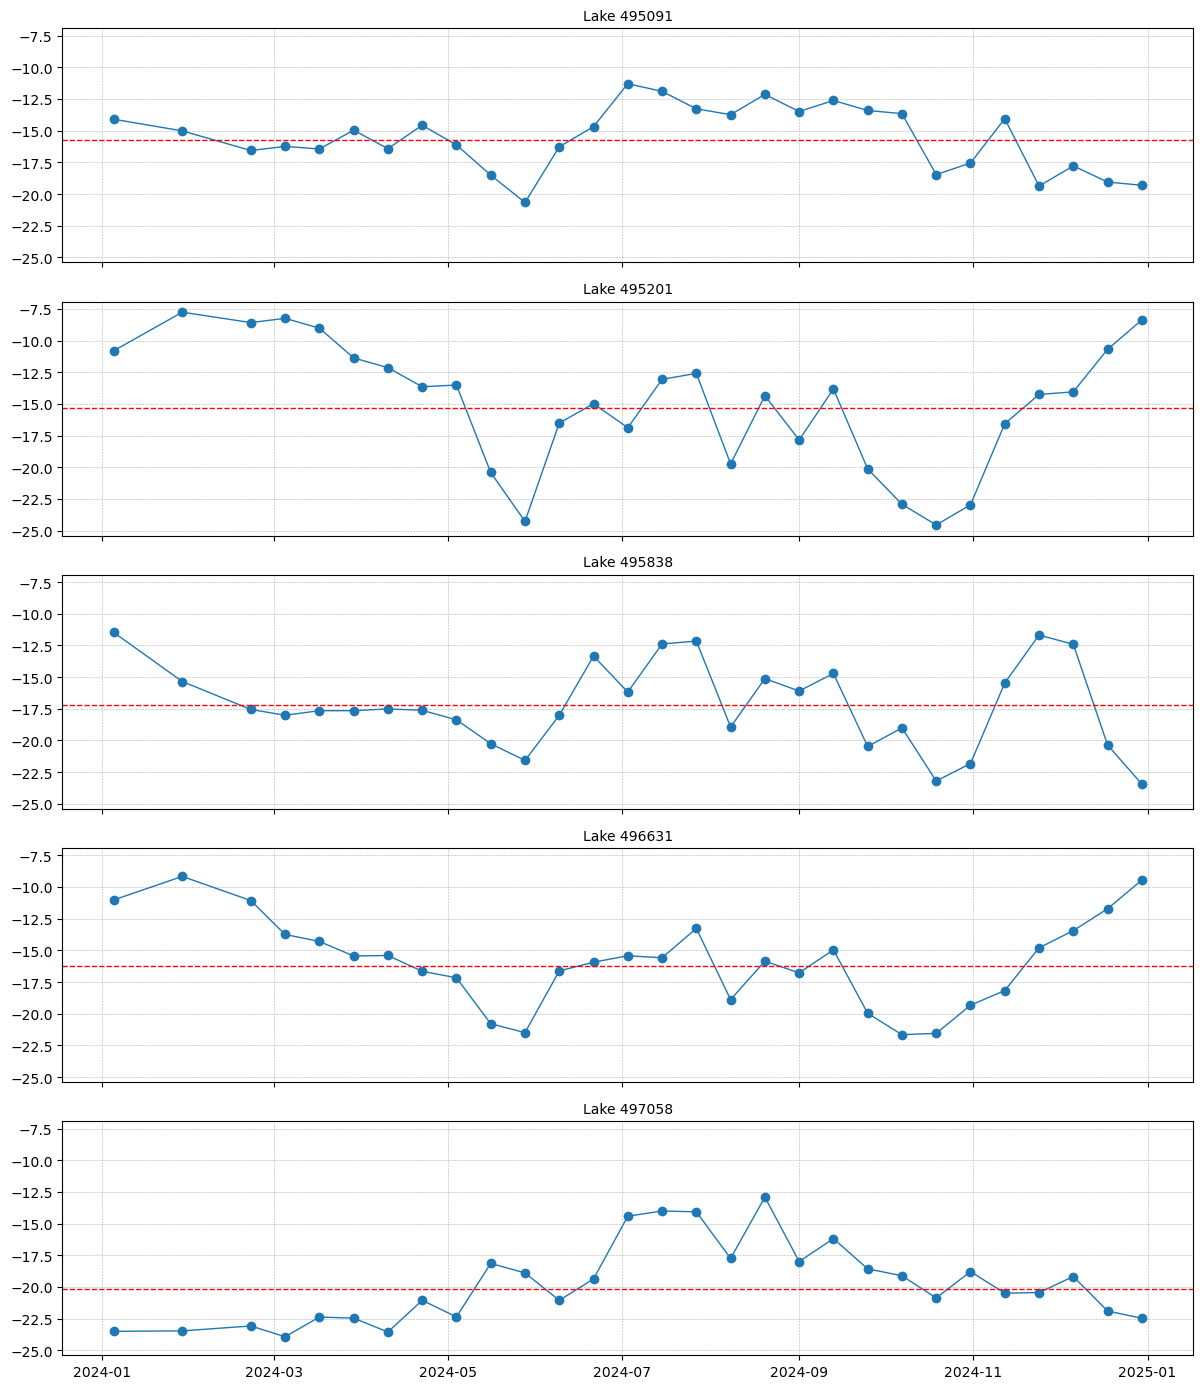

In [19]:
# Make sure date is datetime in the time-series dataframe
df['date'] = pd.to_datetime(df['date'])

# Make sure we have lake_id as an integer
if 'lake_id' not in df.columns:
    df['lake_id'] = df['id'].round().astype('Int64')

# If the summary table exists, rename it to df_events
df_events = summary.copy()

# Make sure lake_id exists there too
if 'lake_id' not in df_events.columns:
    df_events['lake_id'] = df_events['id'].round().astype('Int64')

# Pick the first 5 lakes
lake_ids = df_events['lake_id'].iloc[:5].tolist()

sub = df[df['lake_id'].isin(lake_ids)]

fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.flatten()

for ax, lake_id in zip(axes, lake_ids):
    g = sub[sub['lake_id'] == lake_id].sort_values('date')

    ax.plot(g['date'], g['vv_db'], marker='o', linewidth=1)

    # Lake-specific threshold
    thr = df_events.loc[df_events['lake_id'] == lake_id, 'threshold_vv_db'].iloc[0]
    ax.axhline(thr, color='red', linestyle='--', linewidth=1)

    ax.set_title(f"Lake {lake_id}", fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()

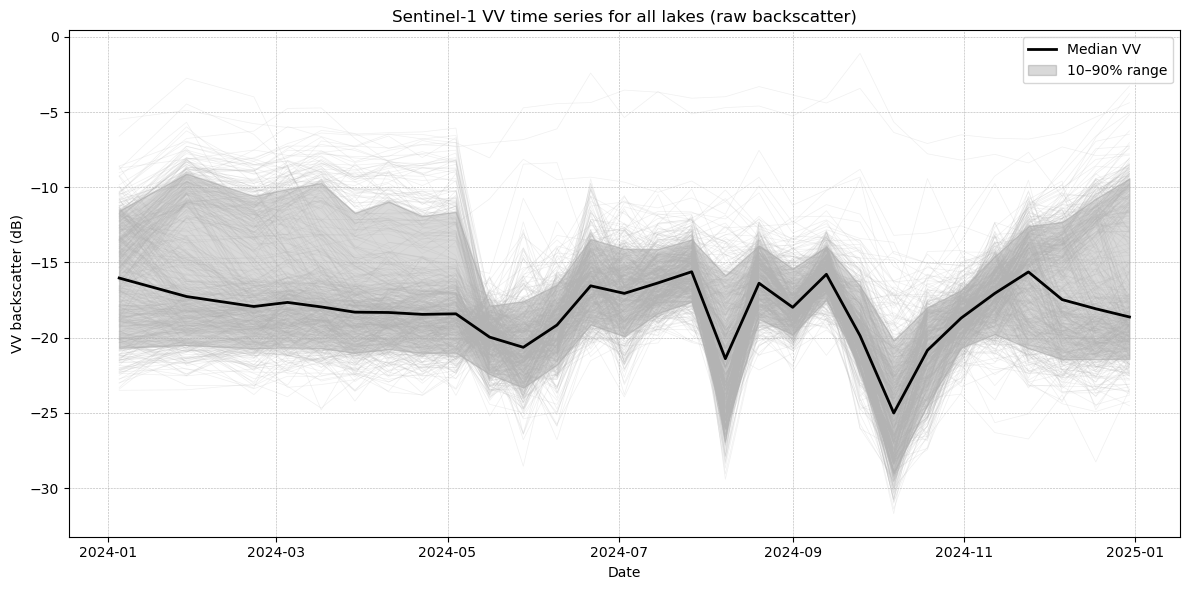

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make sure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Decide which column is the lake identifier
id_col = 'lake_id' if 'lake_id' in df.columns else 'id'

# Sort for nicer plotting
df = df.sort_values(['date', id_col])

# Aggregate across lakes for each date
# You can switch to 'mean' if you prefer, but median is often more robust.
daily = (
    df.groupby('date')['vv_db']
      .agg(
          mean   = 'mean',
          median = 'median',
          p10    = lambda x: x.quantile(0.10),
          p90    = lambda x: x.quantile(0.90),
      )
      .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each lake's time series in light grey
for lake_id, g in df.groupby(id_col):
    ax.plot(
        g['date'],
        g['vv_db'],
        color='0.7',
        alpha=0.2,
        linewidth=0.5,
    )

# Plot the ensemble median as a darker line
ax.plot(
    daily['date'],
    daily['median'],
    color='black',
    linewidth=2,
    label='Median VV'
)

# Add an uncertainty band (10–90 percentile)
ax.fill_between(
    daily['date'],
    daily['p10'],
    daily['p90'],
    color='black',
    alpha=0.15,
    label='10–90% range'
)

ax.set_xlabel('Date')
ax.set_ylabel('VV backscatter (dB)')
ax.set_title('Sentinel-1 VV time series for all lakes (raw backscatter)')
ax.grid(True, linestyle='--', linewidth=0.4)

# Build a simple legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

fig.savefig("all_lakes_raw_timeseries.png",
            dpi=300,
            bbox_inches="tight")

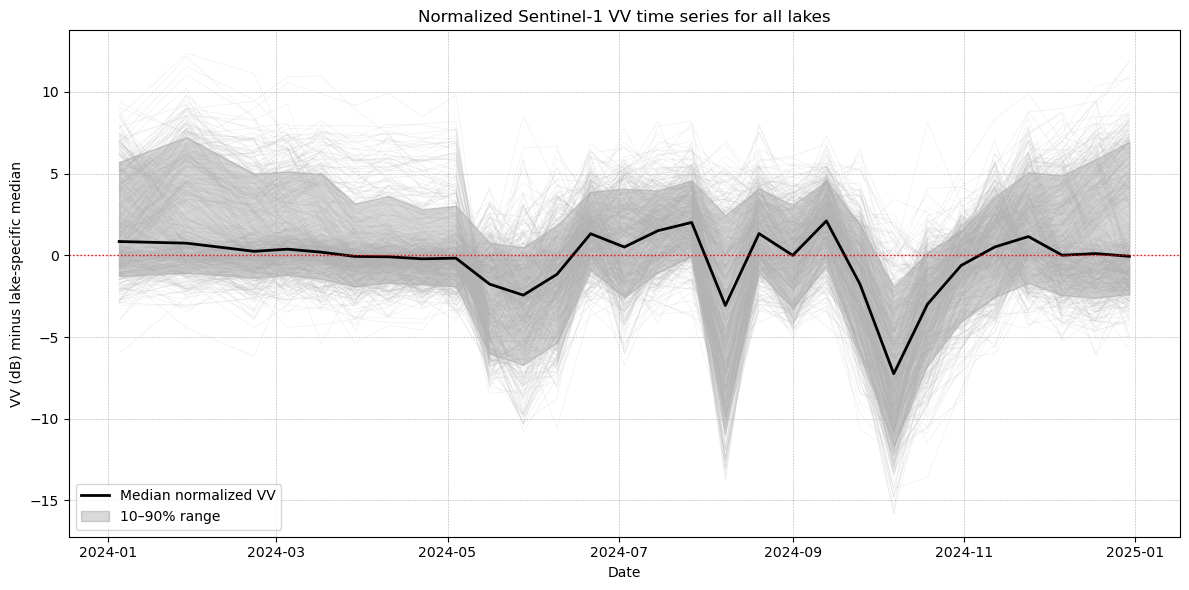

In [21]:
#now the same thing but normalized to each lake's median VV backscatter

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Decide which column is the lake identifier
id_col = 'lake_id' if 'lake_id' in df.columns else 'id'

# Work on a copy
df_norm = df.copy()

# Per-lake median VV, then subtract to center each lake
lake_medians = df_norm.groupby(id_col)['vv_db'].transform('median')
df_norm['vv_norm'] = df_norm['vv_db'] - lake_medians

# Sort for nicer plotting
df_norm = df_norm.sort_values(['date', id_col])

# Aggregate across lakes for each date (normalized VV)
daily_norm = (
    df_norm.groupby('date')['vv_norm']
           .agg(
               mean   = 'mean',
               median = 'median',
               p10    = lambda x: x.quantile(0.10),
               p90    = lambda x: x.quantile(0.90),
           )
           .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each lake's normalized time series in light grey
for lake_id, g in df_norm.groupby(id_col):
    ax.plot(
        g['date'],
        g['vv_norm'],
        color='0.7',
        alpha=0.2,
        linewidth=0.5,
    )

# Plot the ensemble median of normalized VV
ax.plot(
    daily_norm['date'],
    daily_norm['median'],
    color='black',
    linewidth=2,
    label='Median normalized VV'
)

# Add an uncertainty band (10–90 percentile)
ax.fill_between(
    daily_norm['date'],
    daily_norm['p10'],
    daily_norm['p90'],
    color='black',
    alpha=0.15,
    label='10–90% range'
)

# Zero line for reference
ax.axhline(0, color='red', linestyle=':', linewidth=1)

ax.set_xlabel('Date')
ax.set_ylabel('VV (dB) minus lake-specific median')
ax.set_title('Normalized Sentinel-1 VV time series for all lakes')
ax.grid(True, linestyle='--', linewidth=0.4)

# Simple legend without duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

fig.savefig("all_lakes_normalized_timeseries.png",
            dpi=300,
            bbox_inches="tight")

## Plot VV/VH ratio

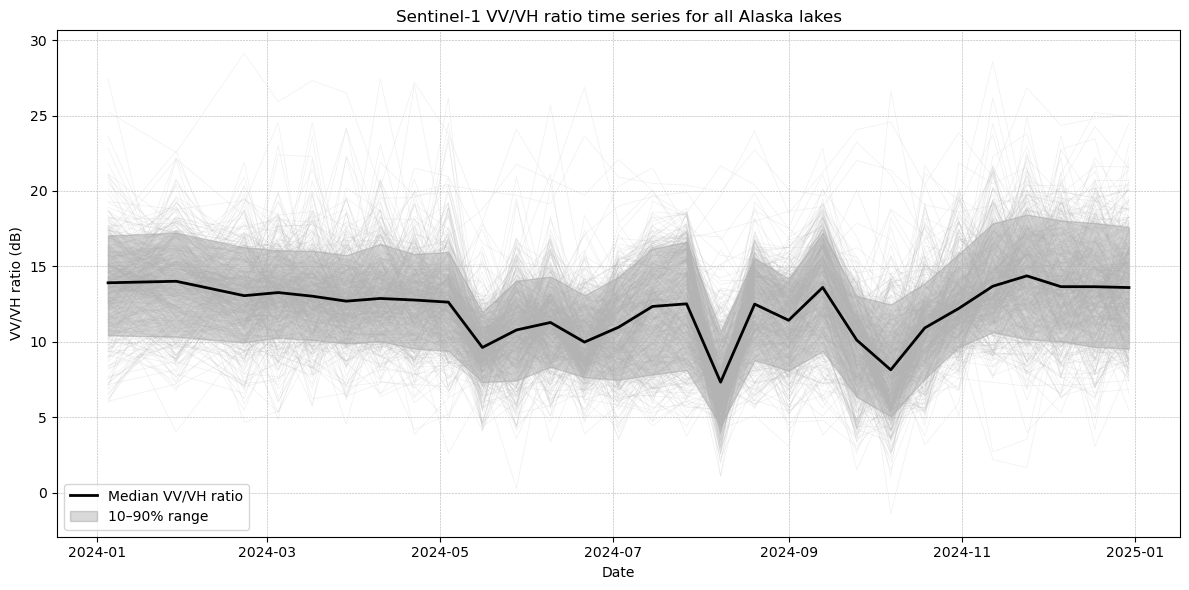

In [25]:
# Make sure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Calculate VV/VH ratio (in logrithimic dB, so this is subtraction)
df['vv_vh_ratio'] = df['vv_db'] - df['vh_db']

# Decide which column is the lake identifier
id_col = 'lake_id' if 'lake_id' in df.columns else 'id'

# Sort for nicer plotting
df = df.sort_values(['date', id_col])

# Aggregate across lakes for each date
daily = (
    df.groupby('date')['vv_vh_ratio']
      .agg(
          mean   = 'mean',
          median = 'median',
          p10    = lambda x: x.quantile(0.10),
          p90    = lambda x: x.quantile(0.90),
      )
      .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each lake's time series in light grey
for lake_id, g in df.groupby(id_col):
    ax.plot(
        g['date'],
        g['vv_vh_ratio'],
        color='0.7',
        alpha=0.2,
        linewidth=0.5,
    )

# Plot the ensemble median as a darker line
ax.plot(
    daily['date'],
    daily['median'],
    color='black',
    linewidth=2,
    label='Median VV/VH ratio'
)

# Add an uncertainty band (10–90 percentile)
ax.fill_between(
    daily['date'],
    daily['p10'],
    daily['p90'],
    color='black',
    alpha=0.15,
    label='10–90% range'
)

ax.set_xlabel('Date')
ax.set_ylabel('VV/VH ratio (dB)')
ax.set_title('Sentinel-1 VV/VH ratio time series for all Alaska lakes')
ax.grid(True, linestyle='--', linewidth=0.4)

# Build a simple legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.tight_layout()
plt.show()

fig.savefig("all_lakes_vv_vh_ratio_timeseries.png",
            dpi=300,
            bbox_inches="tight")

## Another approach?
VV/Vh is still ambiguous. let's plot them against each other and see what's going on

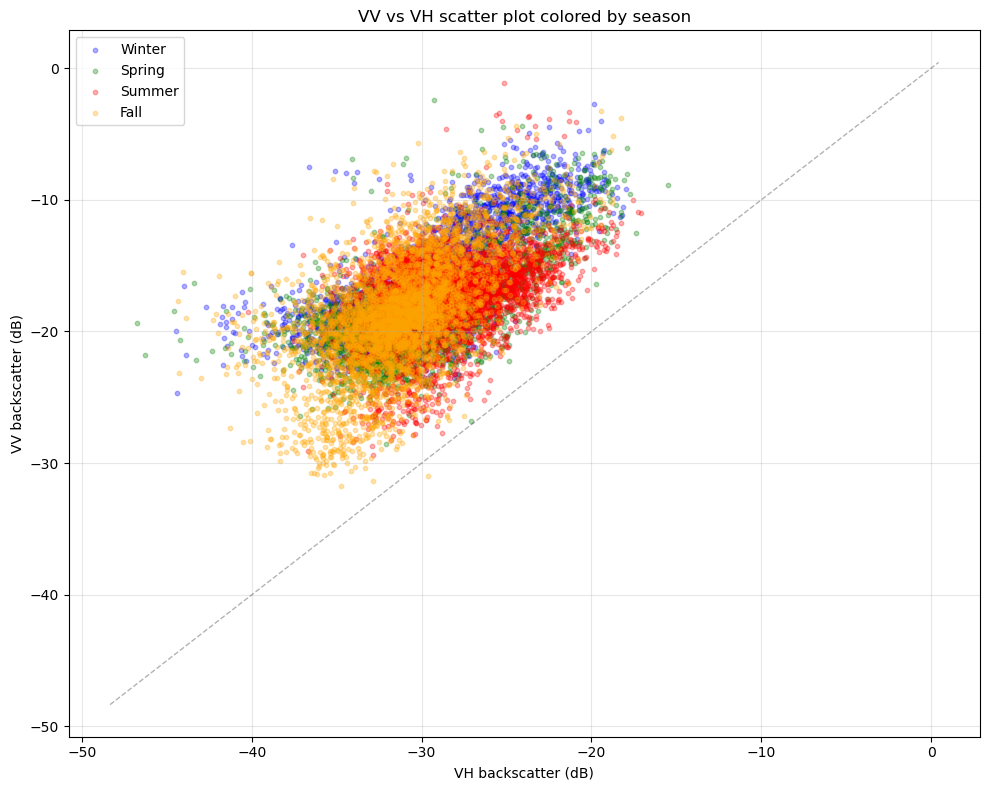

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make sure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Create seasonal categories
df['month'] = df['date'].dt.month
df['season'] = pd.cut(df['month'], 
                       bins=[0, 3, 6, 9, 12],
                       labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'red', 'Fall': 'orange'}

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    mask = df['season'] == season
    ax.scatter(df.loc[mask, 'vh_db'], 
               df.loc[mask, 'vv_db'],
               c=colors[season],
               alpha=0.3,
               s=10,
               label=season)

ax.set_xlabel('VH backscatter (dB)')
ax.set_ylabel('VV backscatter (dB)')
ax.set_title('VV vs VH scatter plot colored by season')
ax.legend()
ax.grid(True, alpha=0.3)

# Add diagonal line for reference (VV = VH)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, linewidth=1, label='VV=VH')

plt.tight_layout()
plt.show()

fig.savefig("vv_vh_scatter_by_season.png", dpi=300, bbox_inches="tight")

## Create RGB composites
Roger's method. The simple methods above are failing

In [34]:
# In your GEE code, for each S1 image, create RGB bands
def create_sar_rgb(img):
    vv = img.select('VV_db')
    vh = img.select('VH_db')
    vv_vh_diff = vv.subtract(vh).rename('VV_VH_diff')
    
    # RGB = (VV, VH, VV-VH)
    # But we need to scale to 0-255 for visualization
    rgb = ee.Image.cat([
        vv.unitScale(-25, 0).multiply(255),      # R channel
        vh.unitScale(-32, -8).multiply(255),     # G channel  
        vv_vh_diff.unitScale(0, 15).multiply(255) # B channel
    ]).byte().rename(['R', 'G', 'B'])
    
    return img.addBands(rgb)

s1_rgb = s1.map(create_sar_rgb)

### Compute color-space 

In [35]:
def extract_color_features(img):
    rgb = img.select(['R', 'G', 'B'])
    
    # For each lake, get RGB statistics
    stats = rgb.reduceRegions(
        collection = lakes_buf,
        reducer = ee.Reducer.mean().combine(
            ee.Reducer.stdDev(), sharedInputs=True
        ),
        scale = 10
    )
    
    def add_color_class(f):
        r = f.get('R_mean')
        g = f.get('G_mean') 
        b = f.get('B_mean')
        
        # Define color-based ice classification
        # Dark blue: low R, low G, high B
        is_water = ee.Number(b).gt(150).And(ee.Number(r).lt(100))
        
        # Orange/red: high R, low G
        is_thick_ice = ee.Number(r).gt(150).And(ee.Number(g).lt(100))
        
        # Light blue: moderate R, low G, moderate B
        is_thin_ice = ee.Number(b).gt(100).And(ee.Number(r).gt(80)).And(ee.Number(r).lt(150))
        
        return f.set({
            'is_water': is_water,
            'is_thick_ice': is_thick_ice,
            'is_thin_ice': is_thin_ice
        })
    
    return stats.map(add_color_class)

### add lake buffer zone

In [38]:
# Create landscape buffer zones (rings around lakes)
def create_landscape_buffer(feat):
    lake_geom = feat.geometry()
    outer_buffer = lake_geom.buffer(100)  # 100m ring
    ring = outer_buffer.difference(lake_geom)  # Subtract lake itself
    return feat.setGeometry(ring)

landscape_rings = lakes.map(create_landscape_buffer)

# Function to extract BOTH lake color AND landscape color from one image
def extract_lake_and_landscape_features(img):
    vv = img.select('VV_db')
    vh = img.select('VH_db')
    
    # Create RGB bands (scaled for visualization)
    r_band = vv.unitScale(-25, 0).multiply(255).byte()
    g_band = vh.unitScale(-32, -8).multiply(255).byte()
    b_band = vv.subtract(vh).unitScale(0, 15).multiply(255).byte()
    
    rgb = ee.Image.cat([r_band, g_band, b_band]).rename(['R', 'G', 'B'])
    
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    
    # Extract RGB from buffered lakes (your existing lakes_buf)
    lake_stats = rgb.reduceRegions(
        collection = lakes_buf,
        reducer = ee.Reducer.mean(),
        scale = 10,
        tileScale = 2
    )
    
    # Extract RGB from landscape rings
    landscape_stats = rgb.reduceRegions(
        collection = landscape_rings,
        reducer = ee.Reducer.mean(),
        scale = 10,
        tileScale = 2
    )
    
    # Combine: add landscape RGB as properties to lake features
    def add_landscape_data(lake_feat):
        lake_id = lake_feat.get(LAKE_ID_FIELD)
        
        # Find matching landscape ring
        landscape_feat = landscape_stats.filter(
            ee.Filter.eq(LAKE_ID_FIELD, lake_id)
        ).first()
        
        # Lake RGB means
        lake_r = ee.Number(lake_feat.get('R'))
        lake_g = ee.Number(lake_feat.get('G'))
        lake_b = ee.Number(lake_feat.get('B'))
        
        # Landscape RGB means
        land_r = ee.Number(landscape_feat.get('R'))
        land_g = ee.Number(landscape_feat.get('G'))
        land_b = ee.Number(landscape_feat.get('B'))
        
        # Color-based classifications
        # Lake is "dark blue" = open water
        is_water = lake_b.gt(150).And(lake_r.lt(100))
        
        # Lake is "orange/light blue" = ice
        is_ice

httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.
httplib2 transport does not support per-request timeout. Set the timeout when constructing the httplib2.Http instance.


Winter: 2024-01-05
Summer: 2024-06-09
Generating thumbnails...


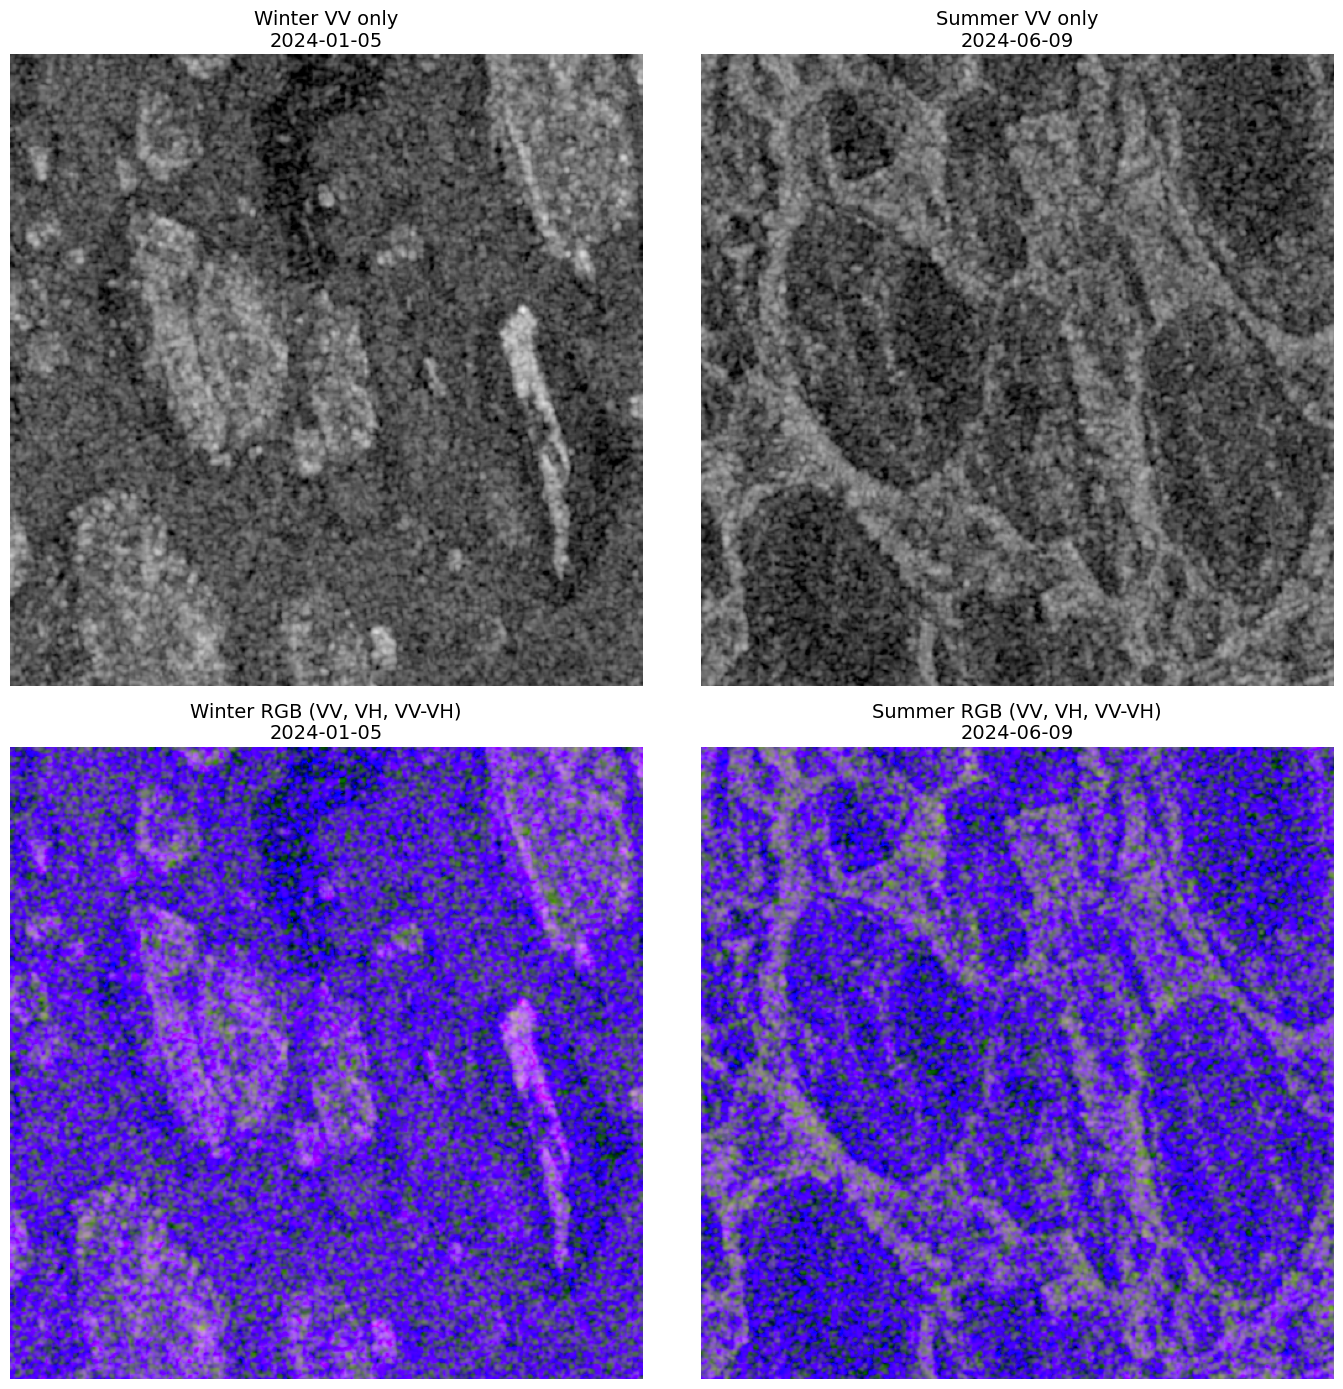


Saved to: lake_comparison_winter_summer.png


In [42]:
from PIL import Image
import requests
from io import BytesIO

ee.Initialize(project='eeps-geospatial')

# Pick one lake
test_lake_id = 495091
test_lake = lakes.filter(ee.Filter.eq('id', float(test_lake_id))).first()
lake_geom = test_lake.geometry()

# Get winter and summer images
winter_img = s1.filterDate('2024-01-01', '2024-03-31').first()
summer_img = s1.filterDate('2024-06-01', '2024-08-31').first()

winter_date = ee.Date(winter_img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
summer_date = ee.Date(summer_img.get('system:time_start')).format('YYYY-MM-dd').getInfo()

print(f"Winter: {winter_date}")
print(f"Summer: {summer_date}")

# Function to get thumbnail URL
def get_thumbnail(image, geom, vis_params, dimensions=512):
    return image.getThumbURL({
        'region': geom.buffer(2000).bounds(),  # 2km buffer around lake
        'dimensions': dimensions,
        'format': 'png',
        **vis_params
    })

# Define visualizations
vv_vis = {'min': -25, 'max': 0, 'palette': ['black', 'white']}
rgb_vis = {'min': [-25, -32, 0], 'max': [0, -8, 15]}

# Create VV and RGB composites
winter_vv = winter_img.select('VV_db')
summer_vv = summer_img.select('VV_db')

winter_rgb = ee.Image.cat([
    winter_img.select('VV_db'),
    winter_img.select('VH_db'),
    winter_img.select('VV_db').subtract(winter_img.select('VH_db'))
])

summer_rgb = ee.Image.cat([
    summer_img.select('VV_db'),
    summer_img.select('VH_db'),
    summer_img.select('VV_db').subtract(summer_img.select('VH_db'))
])

# Get thumbnail URLs
print("Generating thumbnails...")
winter_vv_url = get_thumbnail(winter_vv, lake_geom, vv_vis)
summer_vv_url = get_thumbnail(summer_vv, lake_geom, vv_vis)
winter_rgb_url = get_thumbnail(winter_rgb, lake_geom, rgb_vis)
summer_rgb_url = get_thumbnail(summer_rgb, lake_geom, rgb_vis)

# Download and display
def load_image_from_url(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

print("Downloading images...")
winter_vv_img = load_image_from_url(winter_vv_url)
summer_vv_img = load_image_from_url(summer_vv_url)
winter_rgb_img = load_image_from_url(winter_rgb_url)
summer_rgb_img = load_image_from_url(summer_rgb_url)

# Plot 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].imshow(winter_vv_img)
axes[0, 0].set_title(f'Winter VV only\n{winter_date}', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(summer_vv_img)
axes[0, 1].set_title(f'Summer VV only\n{summer_date}', fontsize=14)
axes[0, 1].axis('off')

axes[1, 0].imshow(winter_rgb_img)
axes[1, 0].set_title(f'Winter RGB (VV, VH, VV-VH)\n{winter_date}', fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(summer_rgb_img)
axes[1, 1].set_title(f'Summer RGB (VV, VH, VV-VH)\n{summer_date}', fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

fig.savefig('lake_comparison_winter_summer.png', dpi=300, bbox_inches='tight')
print("\nSaved to: lake_comparison_winter_summer.png")